# Efficiently Solving Stiff Differential Equations
## An Introduction at the Hand of the Brusselator Problem

In the following we will introduce some ideas around efficiently solving stiff Ordinary Differential Equations (ODEs) or rather systems of them. Let us make the sidenote that an equation is not per se stiff but a particular initial value problem for that equation may be stiff in some regions (C. W. Gear, 1982).

## Imports

In [1]:
# Mathematical tools
using LinearAlgebra
using DifferentialEquations
using Symbolics
using ForwardDiff
using SparseDiffTools
using LSODA
using ODEInterfaceDiffEq
using IterativeSolvers
using LinearMaps
using Random

# Graphs
using Graphs
using NetworkLayout

# General tools
using BenchmarkTools

# Plotting
using Colors, ColorSchemes
using Plots

# Plotting graphs
using CairoMakie
using GraphMakie

## Example stiff ODE system | Brusselator

In this Notebook we consider a simplified "Brusselator" (as discussed in "Solving Ordinar Differential Equations I" by Hairer, Norsett and Wanner) (the Brusselator was originally introduced by Lefefer and Nicolis, 1971). Consider six substances $A, B, D, E, X, Y$ undergoing the following chemical reactions
$$
\begin{array}{rlll}
A & \stackrel{k_1}{\longrightarrow} & X & \\
B+X & \stackrel{k_2}{\longrightarrow} & Y+D & \text { (bimolecular reaction) } \\
2 X+Y & \stackrel{k_3}{\longrightarrow} & 3 X & \text { (autocatalytic trimol. reaction) } \\
X & \stackrel{k_4}{\longrightarrow} & E &
\end{array}
$$
where $A(x), B(x), C(x), ...$ denote concentrations with respect to the place x. As of the mass action law (which you may know as the "Massenwirkungsgesetz" from school) (the rate of a chemical reactions is proportional to the product of the activities or concentrations of the reactants) one follows the following system of differential equations
$$
\begin{aligned}
& A^{\prime}=-k_1 A \\
& B^{\prime}=-k_2 B X \\
& D^{\prime}=k_2 B X \\
& E^{\prime}=k_4 X \\
& X^{\prime}=k_1 A-k_2 B X+k_3 X^2 Y-k_4 X \\
& Y^{\prime}=k_2 B X-k_3 X^2 Y
\end{aligned}
$$
where for simplicity, we
* leave out the equations for $D$ and $E$ as they do not influence the rest
* assume A and B to be constant (maintained) concentrations
* assume all reaction rates to be set to 1
* assume a one-dimensional setting with $0 \le x \le 1$ and constant boundary conditions
* set $u(x):=X(x)$ and $v(x):=Y(x)$
* assume diffusion terms term $\alpha \frac{\partial^2 u}{\partial x^2}$ and $\alpha \frac{\partial^2 v}{\partial x^2}$
and get
$$
\begin{aligned}
& \frac{\partial u}{\partial t}=A+u^2 v-(B+1) u+\alpha \frac{\partial^2 u}{\partial x^2} \\
& \frac{\partial v}{\partial t}=B u-u^2 v+\alpha \frac{\partial^2 v}{\partial x^2}
\end{aligned}
$$
where from dicretizing the differentiation in space (i. e. using the method of lines for approaching this partial differential equations) we follow (with $x_i = \frac{i}{N+1} (1 \le i \le N), \Delta x = \frac{1}{N+1}$, $A = 1$, $B = 3$, $\alpha = \frac{1}{50}$)
$$
\begin{aligned}
u_i^{\prime} & =1+u_i^2 v_i-4 u_i+\frac{\alpha}{(\Delta x)^2}\left(u_{i-1}-2 u_i+u_{i+1}\right), \\
v_i^{\prime} & =3 u_i-u_i^2 v_i+\frac{\alpha}{(\Delta x)^2}\left(v_{i-1}-2 v_i+v_{i+1}\right) \\
u_0(t) & =u_{N+1}(t)=1, \quad v_0(t)=v_{N+1}(t)=3 \\
u_i(0) & =1+\sin \left(2 \pi x_i\right), \quad v_i(0)=3, \quad i=1, \ldots, N .
\end{aligned}
$$
where some boundary conditions have been chosen (constant boundary values enforced using ghost cells). A less simplified Brusselator occurs for instance in nature in the form of the "Oregonator" describing the reactions between $HBrO_2$, $Br^-$ and $Ce(IV)$.

### Implementation of the Brusselator

In [2]:
function brusselator!(dwdt, w, N, t)
    """
    This function returns the right hand side of 
    the ODE system of the Brusselator problem as given
    in "Solving Ordinary Differential Equations II" by 
    Hairer and Wanner.
    """
    # Extract u and v from w, a 1D array of length 2(N + 2)
    u = w[1:N+2]; v = w[N+3:end]

    # Brusselator parameter
    alpha = 1/50

    # Cell size
    h = 1/(N+1)

    # Right hand side of the ODE system, constant boundary conditions
    offset = N + 2

    # dudt[1] = 0; dudt[end] = 0; dvdt[1] = 0; dvdt[end] = 0 not needed
    dwdt[2:N+1] .= 1 .+ u[2:N+1].^2 .* v[2:N+1] .- 4 .* u[2:N+1] .+ alpha ./ h^2 .* (u[1:N] .- 2 .* u[2:N+1] .+ u[3:N+2])
    dwdt[2 + offset:N+1 + offset] .= 3 .* u[2:N+1] .- u[2:N+1].^2 .* v[2:N+1] .+ alpha ./ h^2 .* (v[1:N] .- 2 .* v[2:N+1] .+ v[3:N+2])
    dwdt[1] = 0; dwdt[end] = 0; dwdt[1 + offset] = 0; dwdt[offset] = 0
end

brusselator! (generic function with 1 method)

### Initialization of the Brusselator

In [3]:
# Init brusselator
function init_brusselator(N)
    """
    This function returns the initial values for the 
    Brusselator problem.
    """
    x = range(0, 1, length=N+2)

    u0 = 1 .+ sin.(2 .* pi .* x)
    v0 = zeros(N+2) .+ 3
    u0[1] = 1; u0[end] = 1; v0[1] = 3

    w = vcat(u0, v0)

    return x, w
end

init_brusselator (generic function with 1 method)

### Helpers for the Brusselator system

In [4]:
function sol_to_u_v(sol, N)
    """
    This function returns the solution of the Brusselator
    problem as a tuple of u and v.
    """
    # sol is sadly Vector{Vector{Float64}}
    u = [sol.u[i][j] for i = 1:length(sol.u), j = 1:N+2]
    v = [sol.u[i][j] for i = 1:length(sol.u), j = N+3:length(sol.u[1])]
    return u, v
end

sol_to_u_v (generic function with 1 method)

In [5]:
function wbrusselator!(dwdt, w)
    """
    Wrapped brusselator function that takes a vector w as input.
    N = (length(w) - 2) / 2
    """
    N = Int32(length(w) / 2 - 2)
    brusselator!(dwdt, w, N, 0)
end

wbrusselator! (generic function with 1 method)

In [6]:
function init_ode_prob(N, t_0, t_end, num_saved_steps)
    """
    Returns an ODEProblem for the Brusselator problem.
    """
    tc = range(t_0, t_end, length = num_saved_steps) # saved time steps
    x, w = init_brusselator(N) # initial conditions
    return ODEProblem(brusselator!, w, (t_0, t_end), N), tc, x, w
end

init_ode_prob (generic function with 1 method)

## Sparse matrix and graph functionality

In [7]:
function sparsity_matrix_to_graph(sp_mat)
    """
    Each column of the sparsity matrix is a node in the graph.
    Two nodes are connected if the corresponding columns overlap, i. e.
    if there is a non-zero entry in the same row of both columns.
    """
    # Get number of columns
    n = size(sp_mat, 2)

    # Create empty graph
    g = SimpleGraph(n)

    # Iterate over columns
    for i in 1:n
        # Get indices of non-zero entries in column i
        nz = findall(!iszero, sp_mat[:, i])

        for j in i + 1:n
            # Get indices of non-zero entries in column j
            nz2 = findall(!iszero, sp_mat[:, j])

            # Check if there is a non-zero entry in the same row
            if length(intersect(nz, nz2)) > 0
                # Add edge between column i and j
                add_edge!(g, i, j)
            end
        end
    end

    return g
end


function condense_sparsity_pattern(mat, coloring)
    """
    This function condenses the sparsity pattern of a matrix.
    """
    # number of colors
    n_colors = coloring.num_colors
    # condenset sparsity pattern
    cm = zeros(size(mat, 1), n_colors)
    for i in 1:n_colors
        cm[:, i] = sum(mat[:, coloring.colors .== i], dims=2)
    end
    return cm
end

condense_sparsity_pattern (generic function with 1 method)

## Plot functionality

### Plotting the solution of the ODE system

In [105]:
function plot_as_2D_surface(u, t, x, method, N)
    """
    This function plots the solution of the Brusselator
    problem as a 2D surface.
    """
    # Plot
    f = Plots.surface(x, t, u, xlabel="spatial coordinate x", ylabel="time t", zlabel="concentration u", color=:coolwarm, title = "Simplified Brusselator approached \n via $method \n number of gridpoints N = $N", legend = :none)
    return f
end

function anim_plot_1D(u, N)
    """
    This function animates the solution of the Brusselator
    problem as a 1D line plot.
    """
    x = range(0, stop=1, length=N+2)

    anim = @animate for i in 1:100
        Plots.plot(x, u[i, :], xlims=(0, 1), ylims=(0, 4), xlabel="x", ylabel="u", title="Brusselator", legend=false, grid=true)
    end

    gif(anim, "figures/bruss_ani.gif", fps=10)

end

anim_plot_1D (generic function with 1 method)

### Plotting sparse matrices

In [9]:
function scatter_matrix_plot(mat, cm, title)
    """
    Plot the sparsity pattern of a matrix as a scatter plot.
    """
    x = [i for i in 1:size(mat, 2) for j in 1:size(mat, 1)]
    y = [j for i in 1:size(mat, 2) for j in 1:size(mat, 1)]

    c = [cm[i, j] for j in 1:size(mat, 2) for i in 1:size(mat, 1)]
    
    CairoMakie.scatter(x, y, color = c, marker = :rect, markersize = 50, axis = (aspect = DataAspect(), xgridvisible = false, ygridvisible = false, xticks = 1:size(mat, 2), yticks = 1:size(mat, 1), xlabel = "column-index", ylabel = "row-index", title = title))
    # invert y axis
    CairoMakie.ylims!(size(mat, 1) + 0.8, 0)
    CairoMakie.xlims!(0, size(mat, 2) + 1)
    # show plot
    return CairoMakie.current_figure()
end

function plot_sparsity_pattern_black(mat, title = "Sparsity pattern")
    """
    This function plots the sparsity pattern of a matrix.
    """
    cm = zeros(size(mat, 1), size(mat, 2))
    cm[mat .== 0] .= 0.9
    cm[mat .== 1] .= 0
    cm = RGB.(cm)
    f = scatter_matrix_plot(mat, cm, title);
    display(f)
    return f
end

function plot_sparsity_pattern(mat, colors, title = "Sparsity Pattern")
    """
    This function plots the sparsity pattern of a matrix.
    """
    cm = RGB.(mat)
    cm[mat .== 0] .= 0.9

    # loop through columns and assign color to all non-zero entries
    for i in 1:size(mat, 2)
        cm[mat[:, i] .!= 0, i] .= colors[i]
    end

    cm = RGB.(cm)
    RGB.(cm)

    f = scatter_matrix_plot(mat, cm, title);
    display(f)
    return f
end


plot_sparsity_pattern (generic function with 2 methods)

### Graph plotting

In [10]:
# Use CairoMakie with SVG output
CairoMakie.activate!(type = "svg")

function plot_graph(g, coloring)
    """
    This function plots the graph of the sparsity pattern, colored according to the coloring.
    """
    layout = Stress(Ptype=Float32)
    f, ax, p = graphplot(g, layout = layout, node_color = node_colors(coloring, g), nlabels = repr.(1:nv(g)), nlabels_distance = 0,  nlabels_fontsize=25, elabels_color=:grey, node_size = 60, nlabels_align=(:center,:center))
    
    hidedecorations!(ax); hidespines!(ax)

    # update_limits!(ax)
    # show the plot
    display(f)
    # save as svg
    save("figures/bruss_graph_colored.svg", f)
end

function plot_graph_anim(g, colors, num_colors, i)
    """
    This function plots the graph of the sparsity pattern, colored according to the coloring.
    """

    # White label where black color, black elabels_color
    
    label_colors = [RGB(1, 1, 1) for i in 1:nv(g)]
    label_colors[colors .== RGB(1, 1, 1)] .= RGB(0, 0, 0)

    layout = Stress(Ptype=Float32)
    f, ax, p = graphplot(g, layout = layout, node_color = colors, nlabels = repr.(1:nv(g)), nlabels_color = label_colors, nlabels_distance = 0,  nlabels_fontsize=25, elabels_color=:grey, node_size = 60, nlabels_align=(:center,:center))
    
    hidedecorations!(ax); hidespines!(ax)

    # update_limits!(ax)
    # show the plot
    # display(f)
    # save as svg
    save("figures/cg_anim/cg$i.svg", f)
end

function plot_graph(g)
    """
    This function plots the graph of the sparsity pattern.
    """
    layout = Stress(Ptype=Float32)
    f, ax, p = graphplot(g, layout = layout, node_color = :black, nlabels = repr.(1:nv(g)), nlabels_distance = 0,  nlabels_fontsize=25, nlabels_color = :white, elabels_color=:grey, node_size = 60, nlabels_align=(:center,:center))
    # add a title, title!("Graph of the sparsity pattern") does not work

    # text!(ax, "Graph representation of \n Jacobian sparsity matrix", position=(-1.6, 1), fontsize = 30)

    hidedecorations!(ax); hidespines!(ax)

    # update_limits!(ax)
    # show the plot
    display(f)
    # save as svg
    save("figures/bruss_graph.svg", f)
end

# Fix for GraphMakie labels being displayed outside of the plot
# taken from https://discourse.julialang.org/t/textbox-graph-with-networklayout-with-labels-cut-off-using-graphmakie/96566/4
# by @hexaeder
function update_limits!(ax)
    p = only(ax.scene.plots)
    @assert p isa GraphPlot
    nodep = get_node_plot(p)
    textp = get_nlabel_plot(p)

    to_corners = r -> (Point2f(r.origin[1:2]), Point2f(r.origin[1:2] + r.widths[1:2]))
    to_px = pts -> Makie.project(ax.scene, pts)

    # get lower left and upper right node bounding box in data and px space
    n1_dat, n2_dat = to_corners(boundingbox(nodep))
    n1, n2         = to_px(n1_dat), to_px(n2_dat)

    # get text bounding box in pixel sapce
    t1, t2 = to_corners(boundingbox(textp))

    # get axis limits in data and pixel space
    ax1_dat, ax2_dat = to_corners(ax.finallimits[])
    ax1, ax2         = to_px(ax1_dat), to_px(ax2_dat)

    # check difference between nodelabel and node bounding box in px
    px_diff1 = map(x->min(0, x), t1-n1)
    px_diff2 = map(x->max(0, x), t2-n2)

    # define "targets" in pixelspace where n1 and n2 bounding should end up
    n1_target = ax1-px_diff1 + Point2f(20, 20)
    n2_target = ax2-px_diff2 - Point2f(20, 20)

    # calculate axis limits such as bounding box of node plot goes to target
    scale = (n2_dat - n1_dat) ./ (n2_target - n1_target)
    origin = n1_dat - scale .* (n1_target - ax1)
    width = ((n2_dat - n1_dat) ./ (n2_target - n1_target)) .* (ax2 - ax1)

    CairoMakie.xlims!(ax, origin[1], origin[1]+width[1] )
    CairoMakie.ylims!(ax, origin[2], origin[2]+width[2] )
end

update_limits! (generic function with 1 method)

### Stepping on a 2D heatmap

In [11]:
function plot_heat_stepper(x1, x2, qf, xh, method)
    # plot heatmap
    f = Figure()
    ax = Axis(f[1, 1], xlabel = L"x_1", ylabel = L"x_2", title = "Finding the minimum of the quadratic norm \n for solving Ax = b, where A is ill-conditioned \n method = $method, steps taken = $(size(xh, 2) - 1)")

    CairoMakie.contourf!(x1, x2, (x1, x2) -> qf([x1, x2]), levels = 20, title="Quadratic form", xlabel="x1", ylabel="x2")
    CairoMakie.scatter!([x[1]], [x[2]], markersize=20, markercolor=:red)

    # plot the gradient descent path
    CairoMakie.lines!(xh[1, :], xh[2, :], color=:red, linewidth=2, )

    display(f)
    return f, ax
end

plot_heat_stepper (generic function with 1 method)

## Further helpers

In [12]:
# Plot g with coloring and column indices as labels
function node_colors(coloring, g)
    return [ColorSchemes.tol_light.colors[coloring.colors[i]] for i in 1:nv(g)]
end

function unique_colors(coloring)
    return [ColorSchemes.tol_light.colors[i] for i in 1:coloring.num_colors]
end

unique_colors (generic function with 1 method)

## Trying Explicit Euler on the Brusselator

Let us try explicit Euler on the Brusselator.

In [13]:
# Explicit Euler method
function euler(f, u0, dt, num_steps)
    """
    Explicit Euler method for solving an ODE.
    """
    # Initialize array to store solution
    u = zeros(length(u0), num_steps)
    u[:, 1] .= u0
    # Initialize derivative
    du = zeros(size(u0))
    for i in 2:num_steps
        # Compute derivative
        f(du, u[:, i - 1])
        # Update solution
        u[:, i] .= u[:, i - 1] + dt * du
    end
    return u
end

# Explicit Euler method
function fast_euler(f!, u0, dt, num_steps)
    """
    Explicit Euler method for solving an ODE.
    """
    # Initialize array to store solution
    u = u0
    # Initialize derivative
    du = similar(u0)
    for i in 2:num_steps
        # Compute derivative
        f!(du, u)
        # Update solution
        u += dt * du
    end
    return u
end

function init_explicit_problem(N, t_0, t_end, dt)
    """
    Initialize the explicit problem.
    """
    # Initial conditions
    x, w = init_brusselator(N)
    num_steps = Int(round((t_end - t_0) / dt))
    t = range(t_0, t_end, length = num_steps)
    return x, w, t, num_steps
end

init_explicit_problem (generic function with 1 method)

In [106]:
N = 40; dt = 0.01; t_0 = 0.0; t_end = 10.0;
x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

sol = euler(wbrusselator!, w, dt, num_steps)
u_own = sol[1:N+2, :]';
dt

0.01

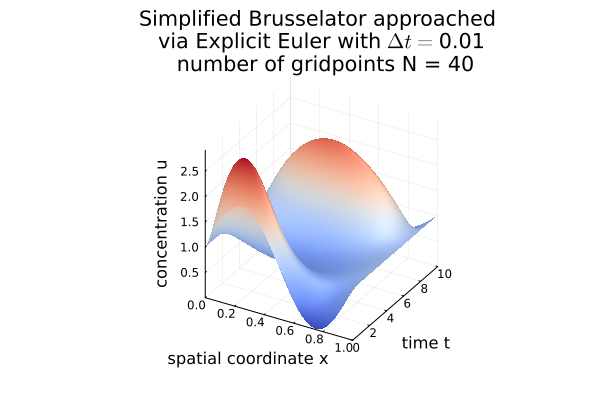

In [107]:
dtr = round(dt, digits = 3)
f = plot_as_2D_surface(u_own, t, x, "Explicit Euler with " * L"\Delta t = " *  "$dtr", N);
save("figures/bruss_ex_eu40.svg", f)
display(f)

### The explicit method has to take excessively small timesteps for large N | stiffness

This does not look too bad, right? But what if we change $N$ to say $400$?

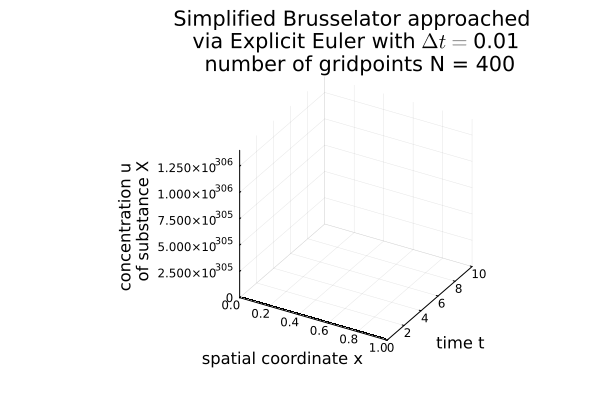

  13.024 ms (17985 allocations: 75.77 MiB)


In [96]:
N = 400; dt = 0.01; t_0 = 0.0; t_end = 10.0;
x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

sol = @btime euler(wbrusselator!, w, dt, num_steps)

u_own = sol[1:N+2, :]';
f = plot_as_2D_surface(u_own, t, x, "Explicit Euler with " * L"\Delta t = " *  "$dt", N)
save("figures/bruss_ex_eu400A.svg", f)
display(f)

Ok, that is not what we want. It turns out that we can avoid this instability by lowering the size of the timestep - but for say $N = 4000$ we quickly run into issues. Let us make the previous a bit more concise using a physical argument:

The transport process at play is diffusion, where for a diffusive process we know for the spreading of some concentration to follow $\sigma = \sqrt{2\alpha t}$. Now in each Euler step we do, only neighboring cells have an effect on each other (compare the discretized ODE we introduced in the beginning). Therefore - in the style of a Courant-Friedrichs-Levy criterium - we can propose the stability constraint
$$\Delta x > \sigma(\Delta t) = \sqrt{2\alpha t}$$
so $\Delta t < \frac{\Delta x^2}{2 \alpha}$. If we want to double $N$ (cut in half $\Delta x$) we need $\mathcal O(N^2)$ more timesteps with the complexity of a function evaluation scaling with $\mathcal O(N)$ resulting in a $\mathcal O(N^3)$ scaling - calculations quickly become unfeasible. As a task to the reader, you can think about implications in higher dimensions.

In [100]:
N = 400;  dt = 0.0001; t_0 = 0.0; t_end = 10.0; # dt = 1 * (1 / (N + 1)) ^ 2 / (2 * 1 / 50);
print(dt)
x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

sol = @btime euler(wbrusselator!, w, dt, num_steps)

end_state = @btime fast_euler(wbrusselator!, w, dt, num_steps)

display(norm(end_state .- sol[:, end]))

u_own = sol[1:N+2, :]';

0.0001  1.614 s (1799985 allocations: 7.41 GiB)


0.0

  1.243 s (1599985 allocations: 5.58 GiB)


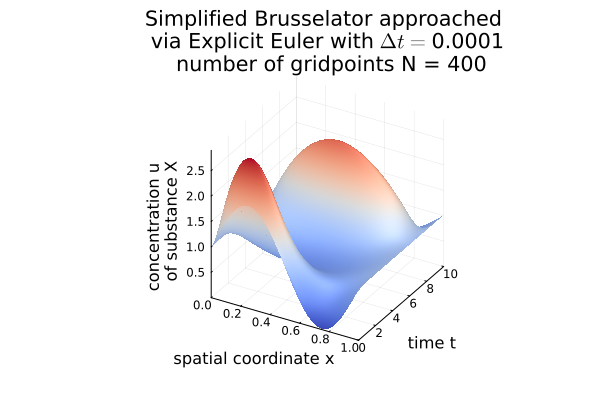

In [101]:
dtr = round(dt, digits = 5)
f = plot_as_2D_surface(u_own, t, x, "Explicit Euler with " * L"\Delta t = " *  "$dtr", N)
save("figures/bruss_ex_eu400B.svg", f)
display(f)

### Checking the normal stiffness indicators I: Eigenvalues of the Jacobian

The result is correct but has taken us lots of time and function evaluations. Let us also analyze the initial Jacobian.

In [19]:
# =============== Analysis of the jacobian at initial conditions ===============

function min_max_abs_ev(N)
    print("Analysis of the jacobian at initial conditions for N = " * string(N) * "\n")
    dwdt0 = zeros(2(N + 2))
    x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)
    J = ForwardDiff.jacobian(wbrusselator!, dwdt0, w)
    # print (absolute) minimum and maximum eigenvalue of the Jacobian
    re = abs.(real(eigvals(J)))
    println("min(abs(re(eigenvalues > 0))): ", minimum(re[re .> 0]))
    println("max(abs(re(eigenvalues))): ", maximum(re))
end

# ======== N = 40 ==========
min_max_abs_ev(40)

# ======== N = 400 ==========
min_max_abs_ev(400)

Analysis of the jacobian at initial conditions for N = 40
min(abs(re(eigenvalues > 0))): 0.31408801361173877
max(abs(re(eigenvalues))): 136.98244050128864


Analysis of the jacobian at initial conditions for N = 400
min(abs(re(eigenvalues > 0))): 0.3210333073507594
max(abs(re(eigenvalues))): 12866.578819965518


### Checking the normal stiffness indicators II: Coefficients of vastly different magnitude in the ODE system

The larger we choose $N$ the larger the stiffness ratio. We can also see this in the frame of the classical "factors of largely different magnitude" indicator for stiffness. Consider the ODE system we solve
$$
\begin{aligned}
u_i^{\prime} & =1+u_i^2 v_i-4 u_i+\frac{\alpha}{(\Delta x)^2}\left(u_{i-1}-2 u_i+u_{i+1}\right), \\
v_i^{\prime} & =3 u_i-u_i^2 v_i+\frac{\alpha}{(\Delta x)^2}\left(v_{i-1}-2 v_i+v_{i+1}\right) \\
u_0(t) & =u_{N+1}(t)=1, \quad v_0(t)=v_{N+1}(t)=3 \\
u_i(0) & =1+\sin \left(2 \pi x_i\right), \quad v_i(0)=3, \quad i=1, \ldots, N .
\end{aligned}
$$
where $\Delta x = \frac{1}{N+1}$ - so there is a factor decreasing quadratically with $N$ in our equation. In addition the system becomes larger and larger with increasing $N$ increasing the computational load.

### Checking the normal stiffness indicators III: Quickly varying solutions nearby

In [20]:
# Task to the reader

## Our Own Simple Implementation of Implicit Euler

We have already seen, that implicit Euler is pretty much unconditionally stable - even for large timesteps. Let us implement implicit Euler in the following and see if we can increase the overall efficiency regarding solving the stiff ODE.

### A first approach without a gain in efficiency

In [21]:
# Mind that the brusselator is defined in place, which could be used to our computational
# advantage but is rather bypassed here.

function g_zero(f!, u, y_n, dt)
    """
    Finding the root of this function is equivalent 
    to finding the next time step in the implicit Euler
    scheme.
    """
    dudt = zeros(length(u))
    f!(dudt, u)
    return u - y_n - dt * dudt
end

function Jg(f!, u, dt)
    """
    Jacobian of g_zero
    """
    N = Int32(length(u) / 2 - 2)
    dwdt0 = zeros(2(N + 2))
    J = ForwardDiff.jacobian(f!, dwdt0, u)
    return I - dt * J
end

function newtons_method(f!, u0, dt, tol, max_iter)
    """
    The root of g_zero (and therefore the next step in time in
    the implicit Euler scheme) is found using Newton's method,
    which is implemented here.
    """
    u = copy(u0) 
    for i in 1:max_iter
        #################################################
        # Here the LU decomposition is performed
        # the full Jacobian is constructed in every step
        luJ = lu(Jg(f!, u, dt)) # Jg(f!, u, dt) constructs
        #                                       the Jacobian
        #################################################
        a = luJ \ g_zero(f!, u, u0, dt)
        u .= u .- a
        if norm(g_zero(f!, u, u0, dt)) < tol
            return u
        end
    end
    return u
end

function implicit_euler(f!, g, zero_finder, dt, w, num_steps)
    """
    A stiff differential equation can be
    solved using the implicit Euler scheme.
    """
    N = Int32(length(w) / 2 - 2)
    u = zeros(2(N + 2), num_steps)
    u[:, 1] = w
    for i in 2:num_steps
        u[:, i] = zero_finder(f!, u[:, i - 1], dt, 1e-4, 1000)
    end
    return u
end

implicit_euler (generic function with 1 method)

#### Test of our first implementation

In [22]:
N = 400; dt = 0.1; x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

# Our solution
sol = @btime implicit_euler(wbrusselator!, g_zero, newtons_method, dt, w, num_steps)
u_own = sol[1:N+2, :]';

  6.477 s (396055 allocations: 11.48 GiB)


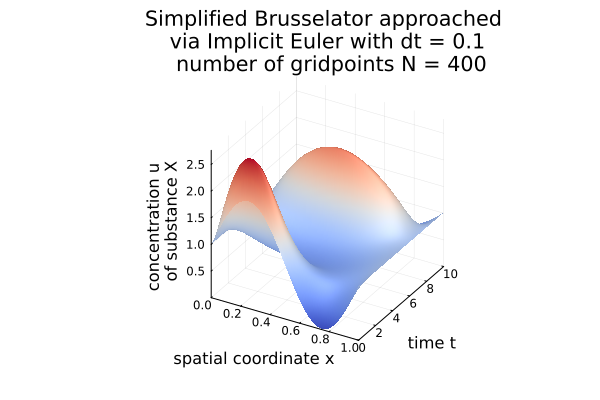

In [23]:
plot_as_2D_surface(u_own, t, x, "Implicit Euler with dt = $dt", N)

In [24]:
sol = @btime implicit_euler(wbrusselator!, g_zero, newtons_method, dt, w, num_steps)

  6.477 s (396055 allocations: 11.48 GiB)


804×100 Matrix{Float64}:
 1.0      1.0      1.0      1.0      1.0      …  1.0       1.0       1.0
 1.01567  1.01982  1.02416  1.02751  1.02926     0.994123  0.994099  0.994102
 1.03133  1.03963  1.04832  1.05502  1.05852     0.988248  0.9882    0.988205
 1.04699  1.05946  1.07249  1.08252  1.08776     0.982375  0.982304  0.982311
 1.06263  1.07929  1.09667  1.11003  1.11699     0.976508  0.976412  0.976422
 1.07826  1.09912  1.12085  1.13752  1.1462   …  0.970646  0.970526  0.970538
 1.09387  1.11896  1.14504  1.16501  1.17538     0.964792  0.964648  0.964661
 1.10946  1.13882  1.16924  1.19249  1.20452     0.958948  0.958779  0.958793
 1.12502  1.15867  1.19344  1.21996  1.23361     0.953114  0.95292   0.952935
 1.14055  1.17854  1.21765  1.2474   1.26265     0.947292  0.947072  0.947088
 ⋮                                            ⋱                      
 3.0      3.01803  3.02994  3.0388   3.04593  …  3.0514    3.05522   3.05875
 3.0      3.01587  3.02632  3.03408  3.04031     3.04

### Quasi-Newton as a first improvement

We see that even for $\Delta t = 0.1$ at $N = 400$ we have no stability issues. However, the LU decomposition takes $\mathcal O(N^3)$ operations and we calculate this multiple times in each step where building the Jacobian without optimizations takes $\mathcal O(N)$ function evaluations (of a function $f: \rm I\!R^{2(N+2)} \rightarrow \rm I\!R^{2(N+2)}$). We can improve by using a factorization more suited for sparse matrices (which is automatically selected) and quasi-Newton instead of Newton.

In [25]:
function quasi_newtons_method(f!, u0, dt, tol, max_iter)
    """
    The root of g_zero (and therefore the next step in time in
    the implicit Euler scheme) is found using Newton's method,
    which is implemented here.
    """
    u = copy(u0) 
    #################################################
    # Here a matrix decomposition automatically 
    # chosen is performed the full Jacobian is 
    # constructed in every step
    Fac = factorize(Jg(f!, u, dt))
    #################################################
    for i in 1:max_iter
        a = Fac \ g_zero(f!, u, u0, dt)
        u .= u .- a
        if norm(g_zero(f!, u, u0, dt)) < tol
            return u
        end
    end
    return u
end

quasi_newtons_method (generic function with 1 method)

In [26]:
# @btime sol = implicit_euler(wbrusselator!, g_zero, newtons_method, dt, w, num_steps)
u_own = @btime implicit_euler(wbrusselator!, g_zero, quasi_newtons_method, dt, w, num_steps)
u_own = sol[1:N+2, :]';

  3.176 s (197980 allocations: 5.57 GiB)


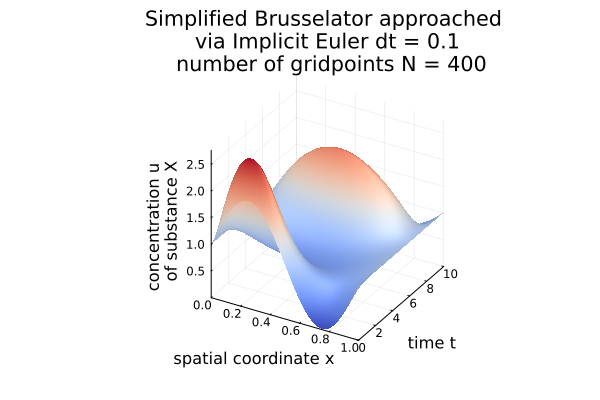

In [27]:
f = plot_as_2D_surface(u_own, t, x, "Implicit Euler dt = $dt", N)
save("figures/bruss_impl_quasi_newton.svg", f)
display(f)

Notice that for each timestep we still calculate the full Jacobian - so $(2(N+2))^2$ entries - which in a naive implementation not using sparsity takes $2(N+2)$ calls of $f$.

### Efficiently constructing the sparse Jacobian

Let us take a look at the sparsity pattern of the Jacobian at the hand of the case $N = 5$ to make things a bit easier to understand and visualize.

#### Initialization of the simplified Brusselator with $N = 5$

In [28]:
# Brusselator parameters
N = 5 # number of grid points
t_0 = 0.0 # initial time
t_end = 10.0 # end time
t = range(t_0, t_end, length=100) # saved time steps
x, w = init_brusselator(N) # initial conditions

# Define the ODE problem
ode_prob = ODEProblem(brusselator!, w, (0, 10), N)

# Solve the ODE problem using a stiff solver
# from the DifferentialEquations package
sol = @btime solve(ode_prob, TRBDF2(), saveat=t);

  531.600 μs (6993 allocations: 761.97 KiB)


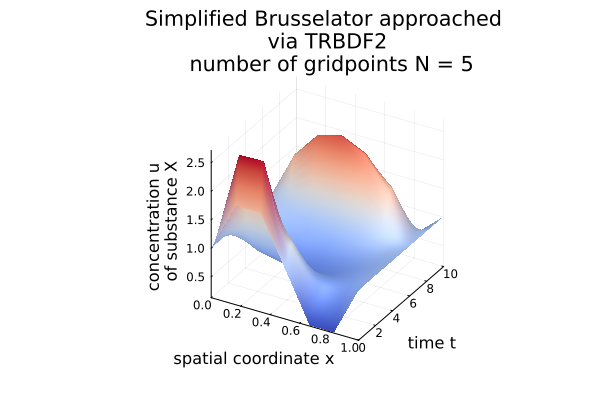

In [29]:
# Plot the solution as a surface over space and time
u, v = sol_to_u_v(sol, N)
f = plot_as_2D_surface(u, t, x, "TRBDF2", N)
display(f)
save("figures/bruss_sparse.svg", f)


┌ Info: Saved animation to c:\Users\leona\OneDrive\Dokumente\Studium\Master\2. Semester\Scientific Machine Learning\Code\figures\bruss_ani.gif
└ @ Plots C:\Users\leona\.julia\packages\Plots\QWCV6\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\leona\\OneDrive\\Dokumente\\Studium\\Master\\2. Semester\\Scientific Machine Learning\\Code\\figures\\bruss_ani.gif")
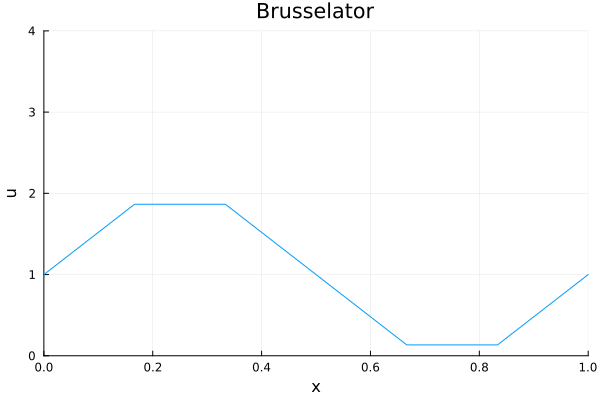

In [30]:
# Animate the the change of the solution over time
anim_plot_1D(u, N)

#### The Jacobian is sparse

14×14 Matrix{Float64}:
 0.0    0.0       0.0       0.0   …   0.0    0.0         0.0        0.0
 0.72   5.75615   0.72      0.0       0.0    0.0         0.0        0.0
 0.0    0.72      5.75615   0.72      0.0    0.0         0.0        0.0
 0.0    0.0       0.72      0.56      1.0    0.0         0.0        0.0
 0.0    0.0       0.0       0.72      0.0    0.0179492   0.0        0.0
 0.0    0.0       0.0       0.0   …   0.0    0.0         0.0179492  0.0
 0.0    0.0       0.0       0.0       0.0    0.0         0.0        0.0
 0.0    0.0       0.0       0.0       0.0    0.0         0.0        0.0
 0.0   -8.19615   0.0       0.0       0.0    0.0         0.0        0.0
 0.0    0.0      -8.19615   0.0       0.72   0.0         0.0        0.0
 0.0    0.0       0.0      -3.0   …  -2.44   0.72        0.0        0.0
 0.0    0.0       0.0       0.0       0.72  -1.45795     0.72       0.0
 0.0    0.0       0.0       0.0       0.0    0.72       -1.45795    0.72
 0.0    0.0       0.0       0.0       0.

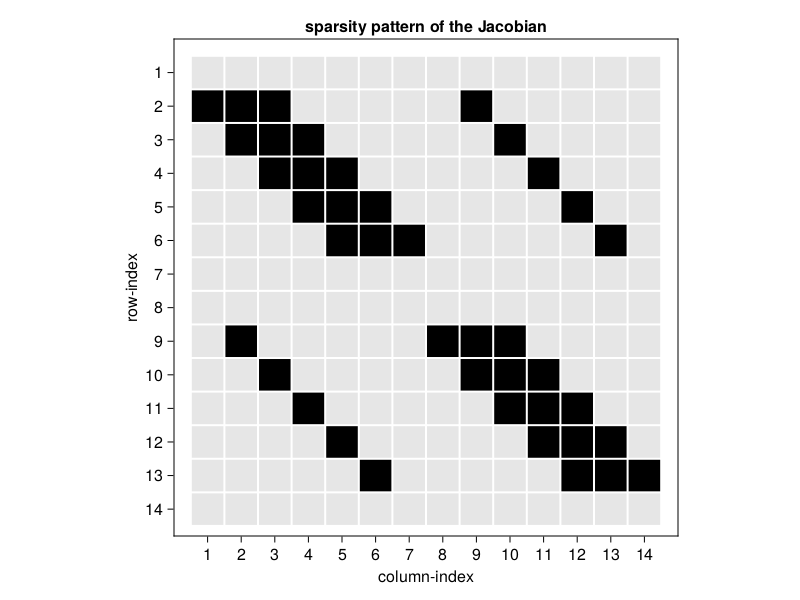

CairoMakie.Screen{SVG}


In [31]:
# Find the sparsity pattern of the Jacobian of the ODE considered
dwdt0 = zeros(2(N + 2)) # initialization of the derivative
sparsity = Symbolics.jacobian_sparsity((du, u) -> brusselator!(du, u, N, 0), dwdt0, w) # find the sparsity pattern
J = ForwardDiff.jacobian(wbrusselator!, dwdt0, w) # find the Jacobian
display(J)

# Plot the sparsity pattern of the Jacobian
f = plot_sparsity_pattern_black(sparsity, "sparsity pattern of the Jacobian")
save("figures/black_sparsity.svg", f)

In [32]:
# Compute the ratio of non-zero elements in the Jacobian
ratio = count(!iszero, sparsity) / length(sparsity)
println("The ratio of non-zero elements in the Jacobian is $ratio for N = $N")

# Compute the sparsity for N = 400
x400, w400 = init_brusselator(400); dwdt0400 = zeros(2(400 + 2)); sparsity400 = Symbolics.jacobian_sparsity((du, u) -> brusselator!(du, u, N, 0), dwdt0400, w400)
ratio400 = count(!iszero, sparsity400) / length(sparsity400)
println("The ratio of non-zero elements in the Jacobian is $ratio400 for N = 400")

The ratio of non-zero elements in the Jacobian is 0.20408163265306123 for N = 5


The ratio of non-zero elements in the Jacobian is 6.187965644414742e-5 for N = 400


Only a few elements in the Jacobian are non-zero - but how can be use this to our advantage in constructing the Jacobian?

Using Automatic Differentiation we need one function call of $f$ to calculate one Jacobian-Vector product (where f is applied to a dual number) and if we choose the unit vectors as directions # columns function evaluation for the whole Jacobian.

However, for non-overlapping columns (those not having a 1 in the same row), we can group multiple unit vectors into one direction we take the directional derivative along and can construct the whole Jacobian with far fewer function calls.

Finding the grouping with the least number of groups grouping the columns of the Jacobian into non-overlapping groups is equivalent to the distance-1 graph coloring problem.

#### Converting the Sparsity Pattern of the Jacobian into a Graph

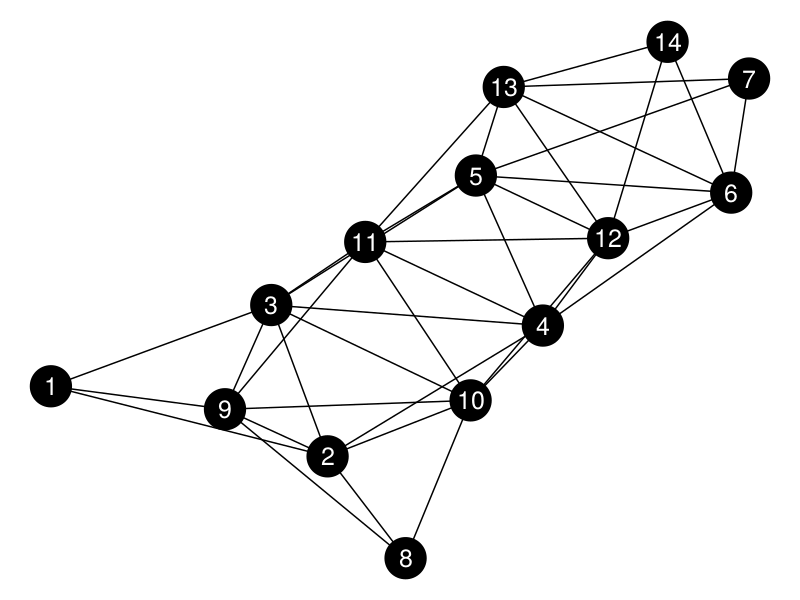

CairoMakie.Screen{SVG}


In [33]:
# Convert the sparsity pattern to a graph
g = sparsity_matrix_to_graph(sparsity)

# Plot the graph
plot_graph(g)

#### Solving the distance-1 Graph coloring problem

Consider the graph where each node represents a column of the sparsity matrix. Two nodes are connected by an edge if the respective columns are overlapping. Finding optimal directions for the directional derivatives then corresponds to finding the optimal distance-1 coloring of the graph.

Graph coloring is NP-complete (perfect coloring takes exponentially long) but we only need to do it once for our Jacobian and we use an approximate non-ideal greedy algorithms for finding groups.

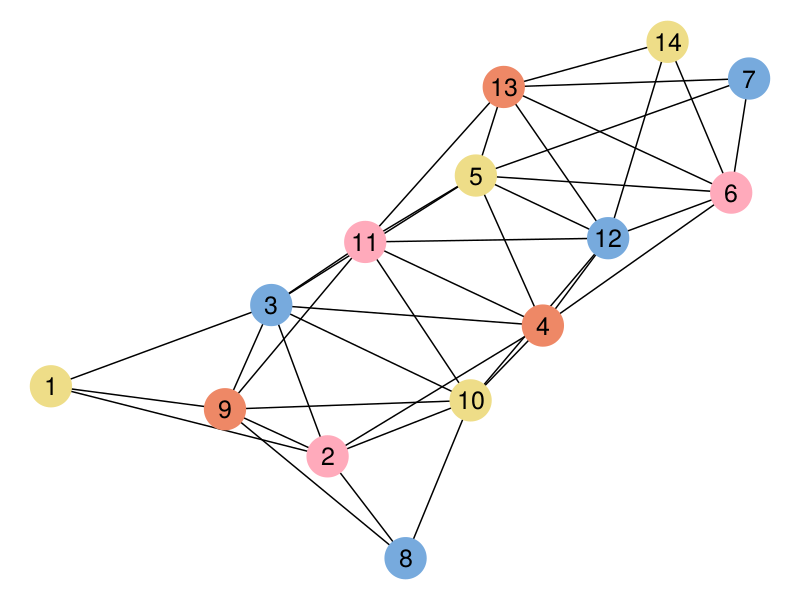

CairoMakie.Screen{SVG}


In [34]:
# Find the distance-1 coloring of the graph
coloring = greedy_color(g; sort_degree = true) 
# a step by step guide through the algorithm can be found below

# Plot the graph with the distance-1 coloring
plot_graph(g, coloring)

In [35]:
####################### Below are two greedy coloring implementations #######################
# you can ignore this

cs = node_colors(coloring, g)
colors = [RGB(0, 0, 0) for i in 1:nv(g)]
# plot_graph_anim(g, colors, 1, 1)
# plot_graph_anim(g, colors, num_colors, step_number)

# based on the greedy algorithm
# 1.	Pick a node at random and assign color 1
# 2.	Color all adjacent nodes with the lowest color possible
#       (e. g. 2 directly after step 1)
# 3.	Repeat step two for all nodes just colored, …
# find and animate the distance-1 coloring of the graph

colors_used = []
colors = [RGB(0, 0, 0) for i in 1:nv(g)]
color_list = ColorSchemes.tol_light.colors
color_indices = zeros(size(colors)) # list of indices of colors used

# Implement the following Python algorithm in Julia
# def first_available(color_list):
#     """Return smallest non-negative integer not in the given list of colors."""
#     color_set = set(color_list)
#     count = 0
#     while True:
#         if count not in color_set:
#             return count
#         count += 1

function first_available(color_list)
    """
    Return smallest non-negative integer not in the given list of colors.
    """
    color_set = Set(color_list)
    count = 1
    while true
        if !(count in color_set)
            return count
        end
        count += 1
    end
end

# Sort the nodes by degree
degree_ordered = sortperm(degree(g), rev=true)

function greedy_coloring(g, pathway)
    colors_used = []
    colors = [RGB(0, 0, 0) for i in 1:nv(g)]
    color_list = ColorSchemes.tol_light.colors
    color_indices = zeros(size(colors)) # list of indices of colors used
    for (k, i) in enumerate(pathway)
        # Find the smallest color not used by the neighbors of node i
        colors_used = [color_indices[j] for j in neighbors(g, i) if color_indices[j] != 0]
        color_indices[i] = first_available(colors_used)
        colors[i] = color_list[Int(color_indices[i])]
        plot_graph_anim(g, colors, k, k)
    end
    return color_indices, colors
end

color_indices, colors = greedy_coloring(g, degree_ordered)
display(color_indices)

# function greedy_coloring(g, pathway)
#     rng = 1:nv(g)

#     best_indices = zeros(size(colors))
#     best_colors = [RGB(0, 0, 0) for i in 1:nv(g)]
#     lowest_num_colors = nv(g)

#     for _ in 1:100
#         rng = shuffle(rng)
#         for i in rng
#             # Find the smallest color not used by the neighbors of node i
#             colors_used = [color_indices[j] for j in neighbors(g, i) if color_indices[j] != 0]
#             color_indices[i] = first_available(colors_used)
#             colors[i] = color_list[Int(color_indices[i])]
#         end
#         num_colors = maximum(color_indices)
#         if num_colors < lowest_num_colors
#             lowest_num_colors = num_colors
#             best_indices = copy(color_indices)
#             best_colors = copy(colors)
#         end
#     end

#     # Plot the graph with the distance-1 coloring
#     maximum(best_indices)
# end


######################## Reference Coloring ########################
# For reference the algorithm from Gebremedhin AH, Manne F, Pothen A. 
# "What color is your Jacobian? Graph coloring for computing derivatives."
# SIAM review. 2005;47(4):629-705. in the implementation of
# https://github.com/JuliaDiff/SparseDiffTools.jl/blob/master/src/coloring/greedy_star1_coloring.jl
# is shown below

function greedy_star2_coloring(g::Graphs.AbstractGraph)
    v = nv(g)
    colorvec = zeros(Int, v)

    forbidden_colors = zeros(Int, v + 1)

    for vertex_i in vertices(g)
        for w in inneighbors(g, vertex_i)
            if colorvec[w] != 0
                forbidden_colors[colorvec[w]] = vertex_i
            end

            for x in inneighbors(g, w)
                if colorvec[x] != 0
                    if colorvec[w] == 0
                        forbidden_colors[colorvec[x]] = vertex_i
                    else
                        if colorvec[x] < colorvec[w]
                            forbidden_colors[colorvec[x]] = vertex_i
                        end
                    end
                end
            end
        end
        colorvec[vertex_i] = find_min_color(forbidden_colors, vertex_i)
    end
    return colorvec
end

function find_min_color(forbidden_colors::AbstractVector, vertex_i::Integer)
    c = 1
    while (forbidden_colors[c] == vertex_i)
        c += 1
    end
    c
end

# display(greedy_star2_coloring(g)) # its sursprisingly bad

####################### End of two greedy coloring implementations #######################

14-element Vector{Float64}:
 3.0
 4.0
 1.0
 2.0
 3.0
 4.0
 1.0
 1.0
 2.0
 3.0
 4.0
 1.0
 2.0
 3.0

find_min_color (generic function with 1 method)

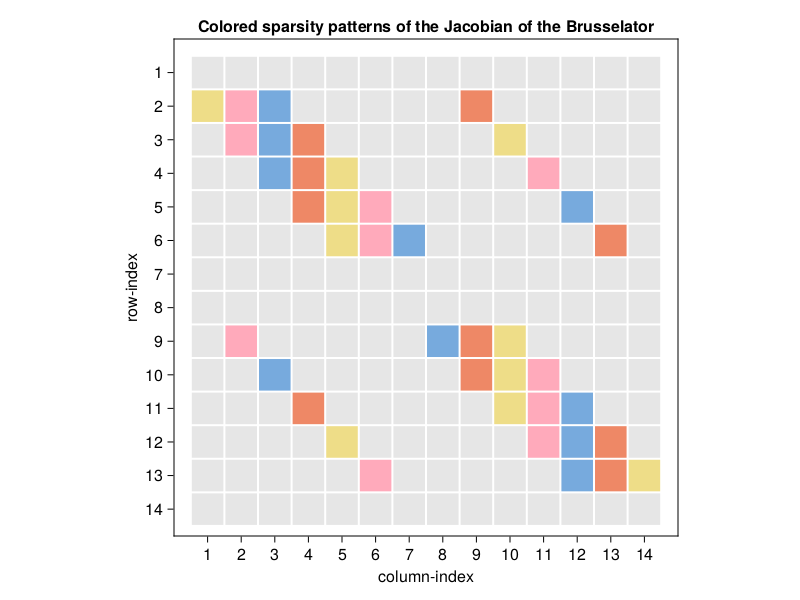

CairoMakie.Screen{SVG}


In [36]:
# Plot the sparsity pattern with the coloring found previously
f = plot_sparsity_pattern(sparsity, node_colors(coloring, g), "Colored sparsity patterns of the Jacobian of the Brusselator")
save("figures/colored_sparsity_pattern.svg", f)

We can combine the directional derivatives of each group given by the same color and later construct the full Jacobian using the sparsity matrix.

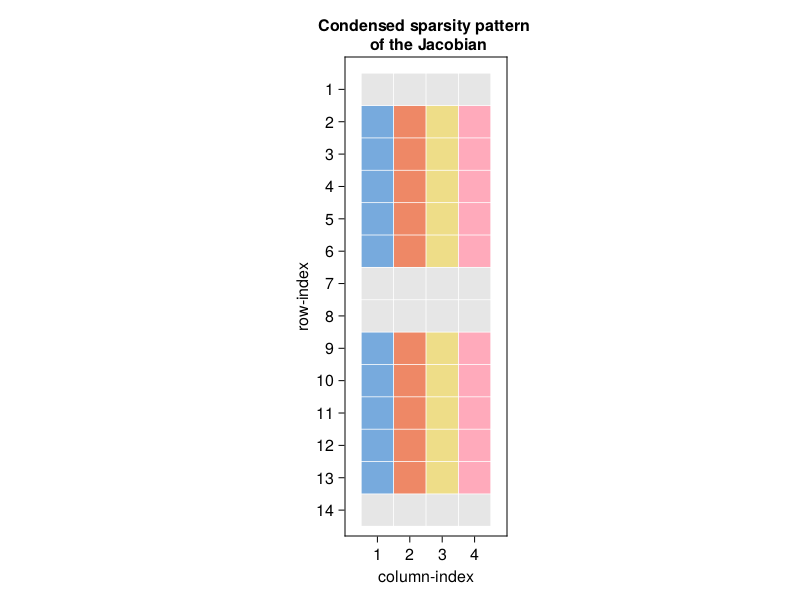

CairoMakie.Screen{SVG}


In [37]:
# Find the condensed pattern, i. e. the matrix resulting from
# overlapping the non-overlapping columns as found by the coloring
cm = condense_sparsity_pattern(sparsity, coloring)

# Plot the condensed pattern
f = plot_sparsity_pattern(cm, unique_colors(coloring), "Condensed sparsity pattern \n of the Jacobian")
save("figures/colored_condensed_sparsity.svg", f)

Using this technique, we can again increase the efficiency of our implicit method.

In [38]:
function do_coloring(N, w)
    dwdt0 = zeros(2(N + 2))
    sparsity = Symbolics.jacobian_sparsity((du, u) -> brusselator!(du, u, N, 0), dwdt0, w) # find the sparsity pattern
    jac = Float64.(sparsity)
    colors = matrix_colors(jac)
    J = similar(jac)
    return J, sparsity, colors
end

function Jg2(f!, u, dt, J, sparsity, colors)
    """
    Jacobian of g_zero
    """
    N = Int32(length(u) / 2 - 2)
    dwdt0 = zeros(2(N + 2))
    forwarddiff_color_jacobian!(J, f!, u, colorvec = colors, sparsity = sparsity)
    return I - dt * J
end

function quasi_newtons_method_c(f!, u0, dt, tol, max_iter, J, sparsity, colors)
    """
    The root of g_zero (and therefore the next step in time in
    the implicit Euler scheme) is found using Newton's method,
    which is implemented here.
    """
    u = copy(u0) 
    #################################################
    # Here a matrix decomposition automatically 
    # chosen is performed the full Jacobian is 
    # constructed in every step
    Fac = factorize(Jg2(f!, u, dt, J, sparsity, colors))
    #################################################
    for i in 1:max_iter
        a = Fac \ g_zero(f!, u, u0, dt)
        u .= u .- a
        if norm(g_zero(f!, u, u0, dt)) < tol
            return u
        end
    end
    return u
end

function implicit_euler_c(f!, g, zero_finder, dt, w, num_steps, J, sparsity, colors)
    """
    A stiff differential equation can be
    solved using the implicit Euler scheme.
    """
    N = Int32(length(w) / 2 - 2)
    u = zeros(2(N + 2), num_steps)
    u[:, 1] = w
    for i in 2:num_steps
        u[:, i] = zero_finder(f!, u[:, i - 1], dt, 1e-4, 1000, J, sparsity, colors)
    end
    return u
end

implicit_euler_c (generic function with 1 method)

In [39]:
N = 400; dt = 0.1; x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)
J, sparsity, colors = do_coloring(N, w)

# Our solution
sol = @btime implicit_euler_c(wbrusselator!, g_zero, quasi_newtons_method_c, dt, w, num_steps, J, sparsity, colors);

  105.937 ms (26232 allocations: 192.25 MiB)


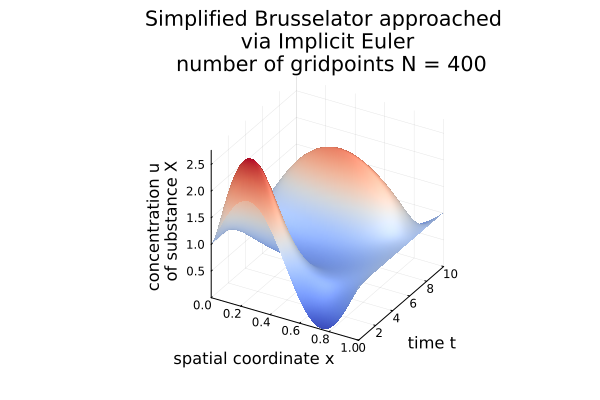

In [40]:
u_own = sol[1:N+2, :]';
f = plot_as_2D_surface(u_own, t, x, "Implicit Euler", N)
save("figures/implicit_euler_colored.svg", f)
display(f)

### Alternative: Jacobian free Newton - Krylov subspace method

In the Newton steps, we solve a system of linear equations. Using Krylov subspace methods this can be done using only matrix (here jacobian) vector products where we can use that one JVP (Jacobian vector product) can be calculated in one forward AD (automatic differentiation) pass.

Solving Linear Systems only based on matrix vector products I: Gradient descent

In [41]:
# Consider the matrix
A = [1 0.1; 0.1 10] # ill-conditioned
b = [1, 1]
# solve the system Ax = b
Af = factorize(A)
x = Af \ b

2-element Vector{Float64}:
 0.990990990990991
 0.09009009009009009

Solving this system is equivalent to finding the minimum of the quadratic form of the matrix A for A positive definite and symmetric.

In [42]:
qf = x -> 0.5 * x' * A * x - b' * x
# plot the quadratic form as a heatmap for x1 and x2 in [-2, 2]
x1 = range(-100, 100, length=100)
x2 = range(-100, 100, length=100)

# plot heatmap
# fig, ax, pl = CairoMakie.contourf(x1, x2, (x1, x2) -> qf([x1, x2]), levels = 20, title="Quadratic form", xlabel="x1", ylabel="x2")
# CairoMakie.scatter!([x[1]], [x[2]], markersize=20, markercolor=:red)
# display(fig)
# Plots.surface(x1, x2, (x1, x2) -> qf([x1, x2]), color = :viridis, xlabel="x1", ylabel="x2", zlabel="qf(x1, x2)")

-100.0:2.0202020202020203:100.0

In [43]:
# Implement and visualize a simple gradient descent
# method for the quadratic form above
function gradient_descent(A, b, x0, tol, max_iter)
    """
    Gradient descent method for the quadratic form qf
    """
    x = copy(x0)
    r = A * x - b
    x_history = zeros(length(x), max_iter)
    x_history[:, 1] .= x
    for i in 2:max_iter
        gamma = (r' * r) / (r' * A * r)
        x = x - gamma * r
        x_history[:, i] .= x
        if norm(r) < tol
            return x, x_history[:, 1:i]
        end
        r = A * x - b
    end
    return x, x_history
end

# Initialize the gradient descent method
x0 = [-100, 100]
tol = 1e-6
max_iter = 1000
x, xh = gradient_descent(A, b, x0, tol, max_iter)
length(xh)

38

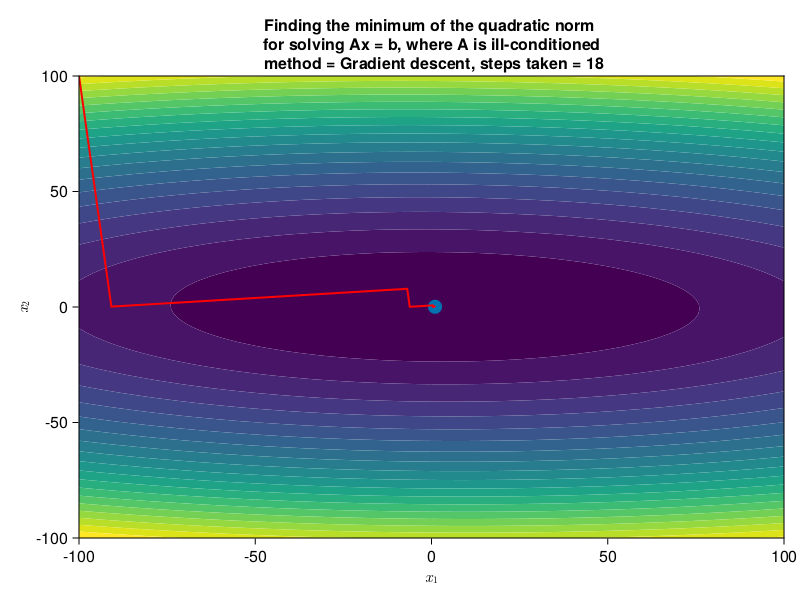

CairoMakie.Screen{SVG}


In [44]:
f, ax = plot_heat_stepper(x1, x2, qf, xh, "Gradient descent");
save("figures/gradient_descent.svg", f)

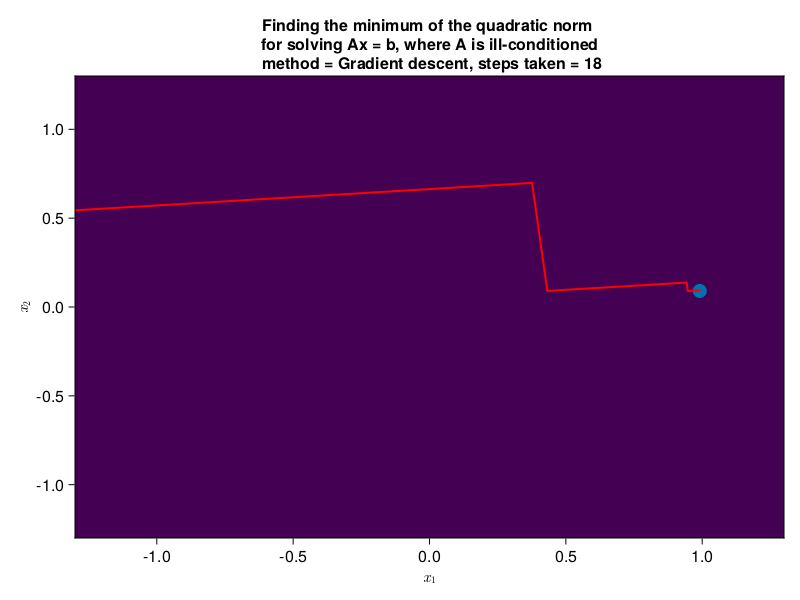

CairoMakie.Screen{IMAGE}


In [45]:
# set x limits to [-10, 10], [-10, 10]
l = 1.3
CairoMakie.xlims!(ax, -l, l)
CairoMakie.ylims!(ax, -l, l)
save("figures/gradient_descent_lims.svg", f)
display(f)

It turns out that the worse-conditioned the matrix is the more steps are needed to find the minimum of its quadratic form in gradient descent. Krylow subspace methods where consecutive step-directions are conjugate with respect to $A$ $((p^i)^T A p^j = 0, i\ne j)$ can be advantageous.

Solving Linear Systems only based on matrix vector products I: Krylow subspace methods

In [46]:
function simple_krylov_solver(A, b, x0, tol, max_iter)
    """
    A simple Krylov subspace solver for Ax = b
    """
    x = copy(x0)
    p = b - A * x

    x_history = zeros(length(x), max_iter)
    x_history[:, 1] .= x

    for n in 2:max_iter
        r = b - A * x
        alpha = (r' * p) / (p' * A * p)
        x = x + alpha * p
        x_history[:, n] .= x
        rn = b - A * x
        if norm(rn) < tol
            return x, x_history[:, 1:n]
        end
        pn = rn + (rn' * rn) / (r' * r) * p
        # println("Directions are conjugate: pn' * A * p = ", pn' * A * p)
        # println("Residuals and steps are mutually orthogonal: rn' * p = ", rn' * p)
        # println("Residuals are orthogonal: rn' * p = ", rn' * r)
        p = pn
    end
    return x, x_history
end

simple_krylov_solver (generic function with 1 method)

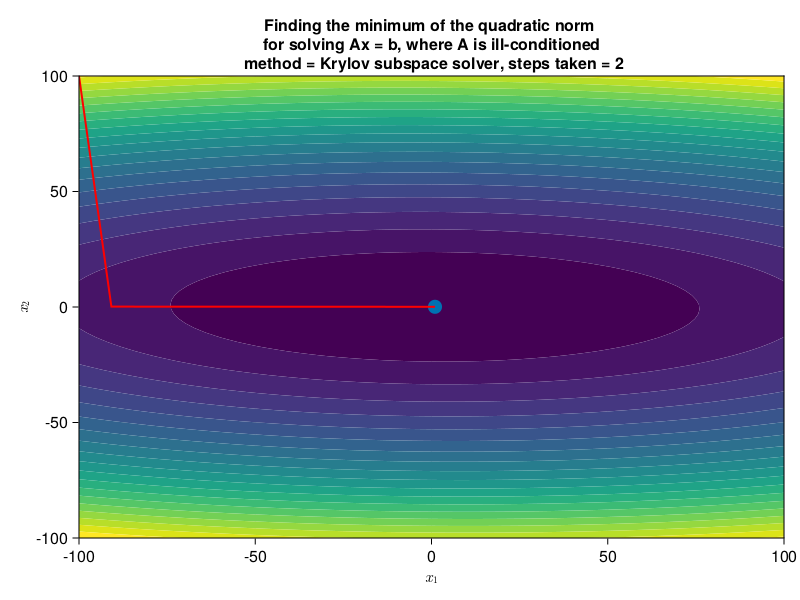

CairoMakie.Screen{SVG}


In [47]:
x, xh = simple_krylov_solver(A, b, x0, tol, max_iter)
f, ax = plot_heat_stepper(x1, x2, qf, xh, "Krylov subspace solver");
save("figures/conjugate_gradient_descent.svg", f)

The problem with the method shown above is that it only works for symmetric pdf matrices. We therefore resort to GMRES. 

Wikipedia: In mathematics, the generalized minimal residual method (GMRES) is an iterative method for the numerical solution of an indefinite nonsymmetric system of linear equations. The method approximates the solution by the vector in a Krylov subspace with minimal residual. The Arnoldi iteration is used to find this vector.

In [48]:
# Test the Krylov solver, with bigger A
A = rand(100, 100)
A = A'*A

println(isposdef(A))

b = rand(100)

x0 = rand(100)
tol = 1e-6
max_iter = 1000

AF = factorize(A)
xc = AF \ b

xk, xkh = simple_krylov_solver(A, b, x0, 1e-5, 1000)

norm(xk - xc)

true


4.097917513119568e-7

#### Krylov subspace methods applied to solving stiff ODEs

In [49]:
function implicit_euler_k(f!, g, zero_finder, dt, w, num_steps)
    """
    A stiff differential equation can be
    solved using the implicit Euler scheme.
    """
    N = Int32(length(w) / 2 - 2)
    u = zeros(2(N + 2), num_steps)
    u[:, 1] = w
    for i in 2:num_steps
        u[:, i] = zero_finder(f!, u[:, i - 1], dt, 1e-2, 10)
    end
    return u
end

#                       |
#                       |   calls
#                       ↓

function newtons_method_k(f!, u0, dt, tol, max_iter)
    """
    The root of g_zero (and therefore the next step in time in
    the implicit Euler scheme) is found using Newton's method,
    which is implemented here.
    """
    u = copy(u0)

    function g!(dudt, u)
        f!(dudt, u)
        dudt[:] = u - u0 - dt * dudt
    end

    # Jm = Jg(f!, u, dt)

    J = JacVec(g!, u0, autodiff = true)

    function mat_vec!(res, w)
        mul!(res,J,w)
    end
    
    Jm = LinearMap(mat_vec!, 2*(N+2); issymmetric = false, ismutating = true)

    for i in 1:max_iter
        a = idrs(Jm, g_zero(f!, u, u0, dt); s = 8, log = false)
        u .= u .- a
        if norm(g_zero(f!, u, u0, dt)) < tol
            return u
        end
    end
    return u
end


#                       |
#                       |   calls
#                       ↓

#                idrs or gmres or ...


# Note: The conjugate gradient method does not work here as the Jacobian is not positive definite
# function krylov_solve(f!, b, dt, x0, tol, max_iter, Jg)
#     """
#     A simple Krylov subspace solver for Jx = b
#     """
#     x = copy(x0)
#     Jg = Jg' * Jg
#     b = Jg' * b

#     # J = JacVec(f!, x0, autodiff = true)
#     # Jg = Jg(f!, x0, dt)

#     # res = similar(x)
#     # mul!(res,J,x)

#     # p = b - (x - dt * res)
#     p = b - Jg * x

#     println(issymmetric(Jg[2:end-1, 2:end-1]))
    
#     for n in 2:max_iter

#         # mul!(res,J,x)
#         # r = b - (x - dt * res)
#         r = b - Jg * x

#         # mul!(res,J,p)
#         # alpha = (r' * p) / (p' * (p - dt * res))
#         alpha = (r' * p) / (p' * Jg * p)
        
#         x = x + alpha * p

#         # mul!(res,J,x)
#         # rn = b - (x - dt * res)
#         rn = b - Jg * x

#         if norm(rn) < tol
#             return x
#         end
#         p = rn + (rn' * rn) / (r' * r) * p
#     end
#     return x
# end

newtons_method_k (generic function with 1 method)

In [50]:
N = 400; dt = 0.1; x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

# Our solution
sol = @btime implicit_euler_k(wbrusselator!, g_zero, newtons_method_k, dt, w, num_steps);

ErrorException: Set autodiff to either AutoForwardDiff(), or AutoFiniteDiff()

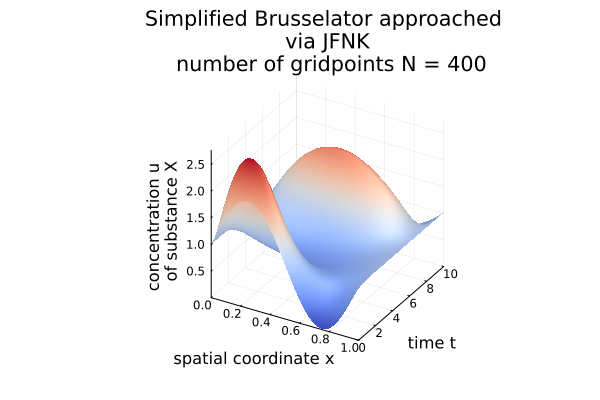

In [51]:
u_own = sol[1:N+2, :]';
f = plot_as_2D_surface(u_own, t, x, "JFNK", N)
save("figures/jnfk.svg", f)
display(f)

## Tests of Methods from the DifferentialEquqtions.jl package

In [52]:
# ==================== Initialize the problem ====================
# ode_prob, tc, x, w = init_ode_prob(40, 0.0, 10.0, 100)
N = 400; t_0 = 0.0; t_end = 10.0; num_saved_steps = 100
tc = range(t_0, t_end, length = num_saved_steps) # saved time steps
x, w = init_brusselator(N) # initial conditions

J, sparsity, colors = do_coloring(N, w)
f! = ODEFunction(brusselator!, jac_prototype = float.(sparsity))
ode_prob = ODEProblem(f!, w, (t_0, t_end), N);

In [53]:
sol_def = @btime solve(ode_prob)
print(sol_def.destats)
print(sol_def.alg)

  13.672 ms (30453 allocations: 27.25 MiB)


DiffEqBase.Stats
Number of function 1 evaluations:                  502
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    28
Number of linear solves:                           388
Number of Jacobians created:                       5
Number of nonlinear solver iterations:             315
Number of nonlinear solver convergence failures:   1
Number of rootfind condition calls:                0
Number of accepted steps:                          46
Number of rejected steps:                          5
Maximum eigenvalue recorded:                       58895

5CompositeAlgorithm{Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, TRBDF2{12, false, KLUFactorization, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val

{:forward}, true, nothing}}, OrdinaryDiffEq.AutoSwitchCache{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, TRBDF2{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}}(

(Tsit5(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false)), TRBDF2{12, false, KLUFactorization, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}(KLUFactorization(true, true), NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}(

1//100, 10, 1//5, 1//5, false, true, 0//1), OrdinaryDiffEq.DEFAULT_PRECS, true, :linear, :PI)), OrdinaryDiffEq.AutoSwitchCache{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, TRBDF2{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Rational{Int64}, Int64}(44, 0, Tsit5(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false)), TRBDF2{0, false, Nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}(nothing, NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}(1//100, 10, 1//5, 1//5, false, true, 0//1), OrdinaryDiffEq.DEFAULT_PRECS, true, :linear, :PI), true, 10, 3, 9//10, 9//10, 2, false, 5))

In [54]:
# ==================== Test some methods from the DifferentialEquqtions.jl package ====================
print("\n====================== Tsitouras 5/4 Runge-Kutta method ======================\n")
print(@btime solve(ode_prob, Tsit5(), saveat=tc).destats)


====================== Tsitouras 5/4 Runge-Kutta method ======================


  2.580 s (3080807 allocations: 9.58 GiB)
DiffEqBase.Stats
Number of function 1 evaluations:                  220047
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          36671
Number of rejected steps:                          3

In [55]:
# print("\n====================== Jacobian-Free Newton Krylov ======================\n")
# print(solve(ode_prob, KenCarp47(linsolve = KrylovJL_GMRES()), save_everystep = false).destats);

In [56]:
# print("\n====================== Rosenbrock23 ======================\n")
# print(@btime solve(ode_prob, Rosenbrock23(autodiff = true), abstol = 1e-2, reltol = 1e-2).destats)

In [57]:
# print("\n====================== Radau ======================\n")
# print(@btime solve(ode_prob, Rodas5P()).destats)

In [58]:
# print("\n====================== lsoda ======================\n")
# print(@btime solve(ode_prob, lsoda()).destats)

In [59]:
# print("\n====================== TRBDF2 ======================\n")
# print(@btime solve(ode_prob, TRBDF2()).destats)